# Running ML on the Mixed Database of logs from LFP and GeoChemDB
Author = Cristina Maria Ruse (crr@equinor.com); Version = 19

## 1. Setting up the interface

In [1]:
# joblib - saving and load models (better than pickle, large jobs)
import joblib

# matplotlib - basic visualization support
import matplotlib.pyplot as plt

# numpy - basic ndarray support
import numpy as np
np.set_printoptions(precision=3)

# pandas - basic dataframe support
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('precision',3)

# pprint - pretty printing
from pprint import pprint

# seaborn - basic visualization support
import seaborn as sns

# pickle
import pickle

# matplotlib - basic visualization support
import matplotlib.pyplot as plt

# numpy - basic ndarray support
import numpy as np
np.set_printoptions(precision=3)

# pandas - basic dataframe support
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('precision',3)

# pprint - pretty printing
from pprint import pprint

# seaborn - basic visualization support
import seaborn as sns

# sklearn - preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

# sklearn - model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# sklearn - machine learning algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# sklearn - metric
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

# sklearn - model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# sklearn - machine learning algorithms
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# sklearn - metric
from sklearn.metrics import mean_squared_error

# sklearn - pipeline
from sklearn.pipeline import Pipeline

# magic commands
%matplotlib inline

## Useful functions

In [2]:
def generate_df(file_csv):
    my_df = pd.read_csv(file_csv)
    print(f"Size of data: \n(no of rows, no of cols) = {my_df.shape}")
    return my_df

def df_drop_edited_logs(df_in):
    my_df = df_in.drop(df_in[df_in.LFP_DTSLOGFLAG < 0.5].index)
    my_df = my_df.drop(my_df[my_df.LFP_DTLOGFLAG < 0.5].index)
    my_df = my_df.drop(my_df[my_df.LFP_RHOBLOGFLAG < 0.5].index)
    print(f"If removing all edited DTS/DT/RHOB data:\n (no of rows, no of cols) = {my_df.shape}")
    return my_df

def make_regplot(X, Y, x_label, y_label, my_regressor):
    my_model = my_regressor
    my_model.fit(X, Y)
    sort_idx = X.flatten().argsort()
    X = X[sort_idx]
    Y = Y[sort_idx]
    plt.scatter(X, Y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, my_regressor.predict(X), color='black', lw=2)    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()
    return 

def scatter_plot(X, Y):
    plt.scatter(X, Y, c='steelblue', edgecolor='white', s=70)
    return 

def scatter_compare_VS(VS_pred, VS_exact, fname):
    sort_idx = VS_pred.flatten().argsort()
    plt.scatter(VS_pred[sort_idx], VS_exact[sort_idx], c='steelblue', edgecolor='white', s=70)
    plt.xlabel('VS_ML')
    plt.ylabel('LFP_VS_B')
    plt.title('LFP VS vs Predicted VS. ' + 'Method =' + fname)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()
    return 

def compare_VS_vals(fname_model, X_valid, Y_valid):
    get_model = joblib.load(fname_model)
    print('\nContents of variable X_validation:')
    pprint(X_valid)
    print('\nContents of variable Y_validation:')
    pprint(Y_valid)
    print('\nPredicted value of the command "get_model.predict(X_validation)":')
    Y_pred = get_model.predict(X_valid)
    pprint(Y_pred)

def load_model(fname):
    loaded_model = load(open(fname, 'rb'))

## 2. Read in the csv data and report on the size

In [3]:
df_cont = generate_df("CONT_SPEKK2.csv")
print("\nVerifying the type of variables:")
df_cont.dtypes

Size of data: 
(no of rows, no of cols) = (7181, 17)

Verifying the type of variables:


WELL                object
DEPTH              float64
TOC_PASSEY         float64
TOC_SCHMOKER       float64
LFP_RHOB           float64
LFP_RHOBLOGFLAG      int64
LFP_VP_B           float64
LFP_VS_B           float64
LFP_VSH            float64
LFP_DTS_LOG        float64
LFP_DT_LOG         float64
LFP_DTSLOGFLAG     float64
LFP_DTLOGFLAG        int64
LFP_GR             float64
LFP_NPHI           float64
LFP_RT             float64
TVDML              float64
dtype: object

## 3. Inspecting the data imported

### 3.1 Values

In [4]:
df_cont.head(10)

,WELL,DEPTH,TOC_PASSEY,TOC_SCHMOKER,LFP_RHOB,LFP_RHOBLOGFLAG,LFP_VP_B,LFP_VS_B,LFP_VSH,LFP_DTS_LOG,LFP_DT_LOG,LFP_DTSLOGFLAG,LFP_DTLOGFLAG,LFP_GR,LFP_NPHI,LFP_RT,TVDML
0,NO_6608/10-4,2356.387,8.484,6.733,2.280,0,2420.485,745.502,0.698,409.511,125.919,1.0,1,73.683,NaN,1.712,1951.146
1,NO_6608/10-4,2366.387,3.020,6.028,2.313,0,2565.123,1008.675,0.735,302.257,118.830,1.0,1,74.378,NaN,0.821,1961.146
2,NO_6608/10-4,2367.262,3.992,6.172,2.306,0,2534.833,947.976,0.758,321.505,120.245,1.0,1,75.173,NaN,0.929,1962.021
3,NO_6608/10-4,2366.512,3.330,6.119,2.309,0,2545.860,980.281,0.746,311.611,119.727,1.0,1,75.378,NaN,0.837,1961.271
4,NO_6608/10-4,2366.262,2.736,5.969,2.316,0,2577.801,1042.893,0.760,292.143,118.202,1.0,1,75.837,NaN,0.800,1961.021
5,NO_6608/10-4,2366.637,3.542,6.186,2.305,0,2531.894,961.222,0.765,317.412,120.383,1.0,1,75.964,NaN,0.846,1961.396
6,NO_6608/10-4,2356.262,8.328,6.836,2.275,0,2400.329,734.215,0.727,416.484,127.002,1.0,1,76.031,NaN,1.580,1951.021
7,NO_6608/10-4,2367.137,3.667,6.097,2.310,0,2550.513,945.888,0.771,322.272,119.497,1.0,1,76.660,NaN,0.903,1961.896
8,NO_6608/10-4,2367.387,4.405,6.286,2.301,0,2511.121,951.608,0.777,320.988,121.390,1.0,1,76.738,NaN,0.955,1962.146
9,NO_6608/10-4,2367.012,3.500,6.086,2.310,0,2552.867,944.184,0.795,322.859,119.361,1.0,1,78.183,NaN,0.879,1961.771


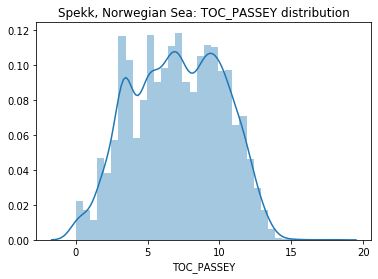

In [5]:
# Is TOC_PASSEY normaly distributed or skewed?
sns2 = sns.distplot(df_cont['TOC_PASSEY']).set_title("Spekk, Norwegian Sea: TOC_PASSEY distribution")

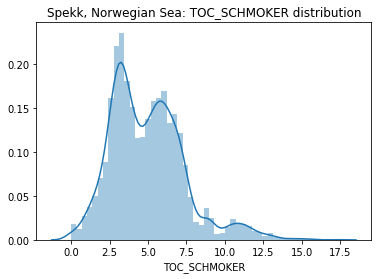

In [6]:
# Is TOC_SCHMOKER normaly distributed or skewed?
sns3 = sns.distplot(df_cont['TOC_SCHMOKER']).set_title("Spekk, Norwegian Sea: TOC_SCHMOKER distribution")

Text(0.5, 1.0, 'Draupne, North Sea: Comparing Box and Whisker Plots')

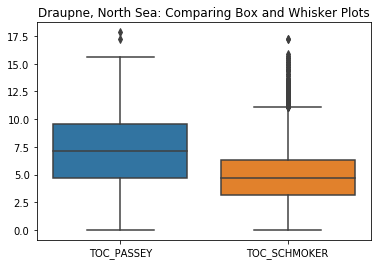

In [7]:
# Box and Whisker Plots
ax = sns.boxplot(data=df_cont[['TOC_PASSEY', 'TOC_SCHMOKER']])
ax.set_title('Draupne, North Sea: Comparing Box and Whisker Plots')

## 4 The consequence of dropping edited data

In [8]:
df2 = df_drop_edited_logs(df_cont)

If removing all edited DTS/DT/RHOB data:
 (no of rows, no of cols) = (4987, 17)


## I have decided on using also the edited data - mainly due to reduction in size

# 5 Features - Transformation 

In [9]:
# Adding columns to the dataframe
df_cont['LOGRT'] = np.log(df_cont['LFP_RT'])
df_cont['LOGTOC_PASSEY'] = np.log(df_cont['TOC_PASSEY'] + 0.1) # prevent singular value
print(f"Size of data: (no of rows, no of cols) = {df_cont.shape}")

Size of data: (no of rows, no of cols) = (7181, 19)


In [10]:
df_cont.head(10)

,WELL,DEPTH,TOC_PASSEY,TOC_SCHMOKER,LFP_RHOB,LFP_RHOBLOGFLAG,LFP_VP_B,LFP_VS_B,LFP_VSH,LFP_DTS_LOG,LFP_DT_LOG,LFP_DTSLOGFLAG,LFP_DTLOGFLAG,LFP_GR,LFP_NPHI,LFP_RT,TVDML,LOGRT,LOGTOC_PASSEY
0,NO_6608/10-4,2356.387,8.484,6.733,2.280,0,2420.485,745.502,0.698,409.511,125.919,1.0,1,73.683,NaN,1.712,1951.146,0.538,2.150
1,NO_6608/10-4,2366.387,3.020,6.028,2.313,0,2565.123,1008.675,0.735,302.257,118.830,1.0,1,74.378,NaN,0.821,1961.146,-0.197,1.138
2,NO_6608/10-4,2367.262,3.992,6.172,2.306,0,2534.833,947.976,0.758,321.505,120.245,1.0,1,75.173,NaN,0.929,1962.021,-0.074,1.409
3,NO_6608/10-4,2366.512,3.330,6.119,2.309,0,2545.860,980.281,0.746,311.611,119.727,1.0,1,75.378,NaN,0.837,1961.271,-0.178,1.232
4,NO_6608/10-4,2366.262,2.736,5.969,2.316,0,2577.801,1042.893,0.760,292.143,118.202,1.0,1,75.837,NaN,0.800,1961.021,-0.224,1.042
5,NO_6608/10-4,2366.637,3.542,6.186,2.305,0,2531.894,961.222,0.765,317.412,120.383,1.0,1,75.964,NaN,0.846,1961.396,-0.167,1.292
6,NO_6608/10-4,2356.262,8.328,6.836,2.275,0,2400.329,734.215,0.727,416.484,127.002,1.0,1,76.031,NaN,1.580,1951.021,0.458,2.132
7,NO_6608/10-4,2367.137,3.667,6.097,2.310,0,2550.513,945.888,0.771,322.272,119.497,1.0,1,76.660,NaN,0.903,1961.896,-0.102,1.326
8,NO_6608/10-4,2367.387,4.405,6.286,2.301,0,2511.121,951.608,0.777,320.988,121.390,1.0,1,76.738,NaN,0.955,1962.146,-0.046,1.505
9,NO_6608/10-4,2367.012,3.500,6.086,2.310,0,2552.867,944.184,0.795,322.859,119.361,1.0,1,78.183,NaN,0.879,1961.771,-0.129,1.281


# 6 Selecting final logs

In [11]:
# This subset are those that I consider interesting:
# 8 input variables (positions 0:8)
# 1 output variable (position 8)
my_list = ['LFP_VSH', 'LFP_NPHI', 'LFP_RHOB', 'TVDML', 'LOGRT', 'TOC_PASSEY', 'LOGTOC_PASSEY', 'LFP_VP_B', 'LFP_VS_B']

In [12]:
df = df_cont[my_list]
print(f"Size of data: (no of rows, no of cols) = {df.shape}")

Size of data: (no of rows, no of cols) = (7181, 9)


### Moderate change of rows when dropping rows where at least one element is missing

In [13]:
df3 = df.dropna()
df3.shape

(6557, 9)

In [14]:
df3.head(10)

,LFP_VSH,LFP_NPHI,LFP_RHOB,TVDML,LOGRT,TOC_PASSEY,LOGTOC_PASSEY,LFP_VP_B,LFP_VS_B
352,0.990,0.049,2.369,3467.449,1.895,9.484,2.260,3018.572,1579.562
353,0.990,0.060,2.370,3469.885,1.960,9.806,2.293,3020.163,1587.344
354,0.501,0.076,2.608,3542.970,2.209,2.198,0.832,4474.166,2385.058
355,0.511,0.088,2.582,3535.667,1.815,2.261,0.859,3960.620,2185.644
356,0.524,0.091,2.577,3546.469,2.404,2.617,1.000,4526.369,2559.774
357,0.510,0.092,2.571,3543.578,2.259,2.435,0.930,4420.911,2393.185
358,0.990,0.092,2.157,1354.741,0.386,10.475,2.359,2244.412,861.251
359,0.990,0.093,2.366,3469.788,1.957,9.950,2.308,3000.015,1592.383
360,0.543,0.096,2.576,3535.362,1.798,1.713,0.595,4178.480,2249.341
361,0.609,0.099,2.609,3546.317,2.436,2.666,1.017,4546.791,2569.969


# 7 Descriptive Statistics

In [15]:
df3.describe()

,LFP_VSH,LFP_NPHI,LFP_RHOB,TVDML,LOGRT,TOC_PASSEY,LOGTOC_PASSEY,LFP_VP_B,LFP_VS_B
count,6557.000,6557.000,6557.000,6557.000,6557.000,6557.000,6557.000,6557.000,6557.000
mean,0.899,0.374,2.374,2739.902,1.102,7.195,1.848,2858.087,1429.767
std,0.116,0.145,0.120,781.680,0.677,3.124,0.640,423.002,327.981
min,0.501,0.049,1.876,831.033,-1.043,0.000,-2.303,2019.356,670.893
25%,0.836,0.266,2.305,2451.108,0.607,4.708,1.570,2619.426,1254.340
50%,0.951,0.360,2.387,2663.329,1.043,7.253,1.995,2796.330,1458.789
75%,0.990,0.426,2.461,3455.253,1.706,9.741,2.287,3048.198,1619.602
max,1.000,1.061,2.814,4091.735,2.803,17.837,2.887,4818.291,2631.687


# 8 Correlations - scatter plot matrix and correlation values

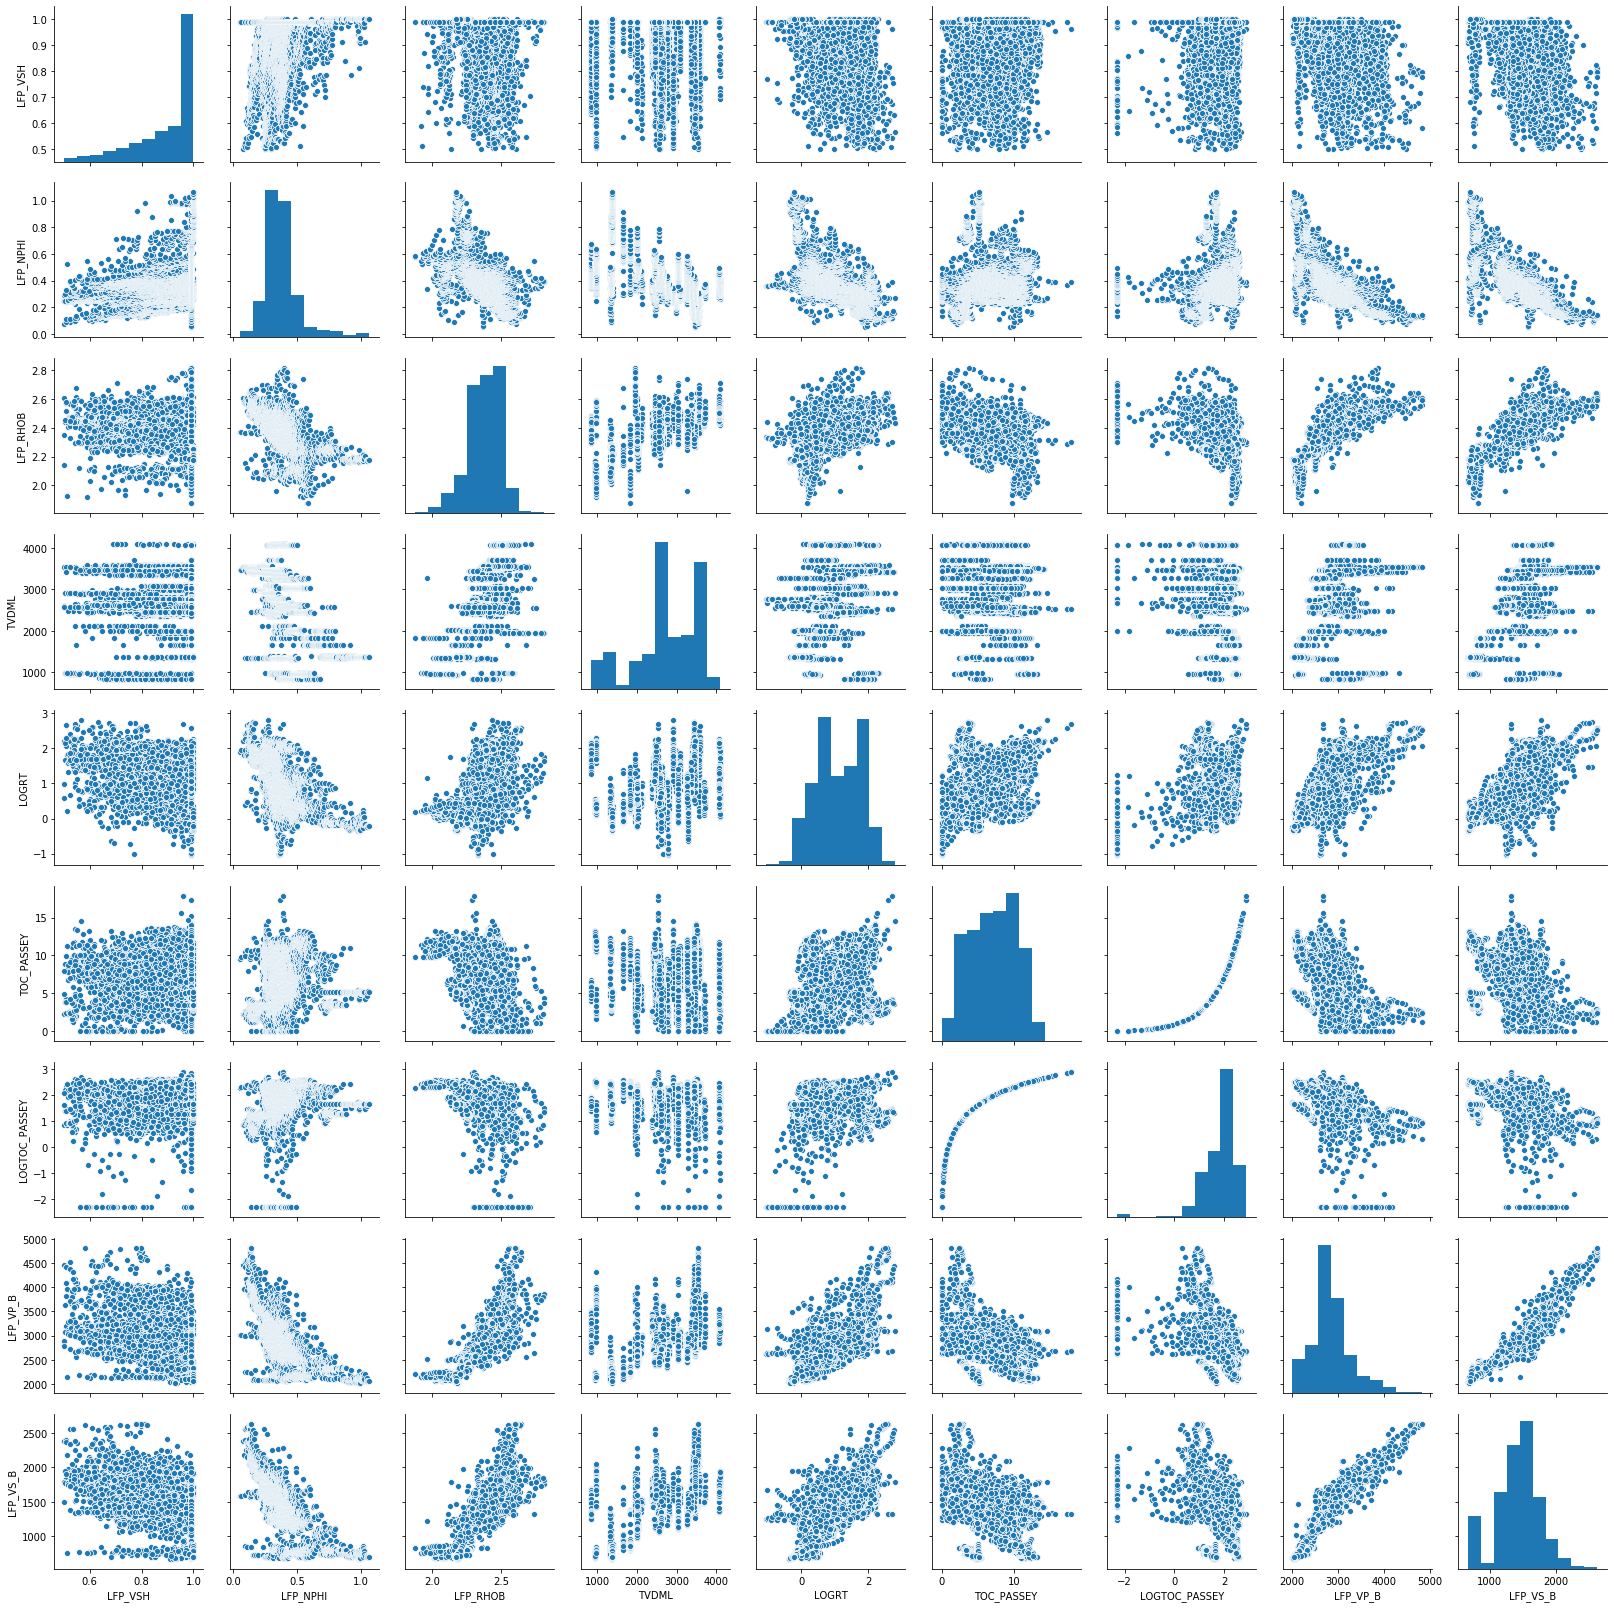

In [16]:
sns.pairplot(df3)
plt.show()

In [17]:
# Pearson correlation coefficient between the variables
df3.corr(method='pearson')

,LFP_VSH,LFP_NPHI,LFP_RHOB,TVDML,LOGRT,TOC_PASSEY,LOGTOC_PASSEY,LFP_VP_B,LFP_VS_B
LFP_VSH,1.000,0.263,-0.162,0.024,-0.226,0.220,0.196,-0.382,-0.393
LFP_NPHI,0.263,1.000,-0.638,-0.662,-0.677,-0.026,0.045,-0.677,-0.757
LFP_RHOB,-0.162,-0.638,1.000,0.648,0.622,-0.333,-0.337,0.801,0.826
TVDML,0.024,-0.662,0.648,1.000,0.563,0.015,-0.046,0.538,0.663
LOGRT,-0.226,-0.677,0.622,0.563,1.000,0.257,0.222,0.657,0.727
TOC_PASSEY,0.220,-0.026,-0.333,0.015,0.257,1.000,0.880,-0.485,-0.330
LOGTOC_PASSEY,0.196,0.045,-0.337,-0.046,0.222,0.880,1.000,-0.485,-0.339
LFP_VP_B,-0.382,-0.677,0.801,0.538,0.657,-0.485,-0.485,1.000,0.942
LFP_VS_B,-0.393,-0.757,0.826,0.663,0.727,-0.330,-0.339,0.942,1.000


### Heatmap with Seaborn

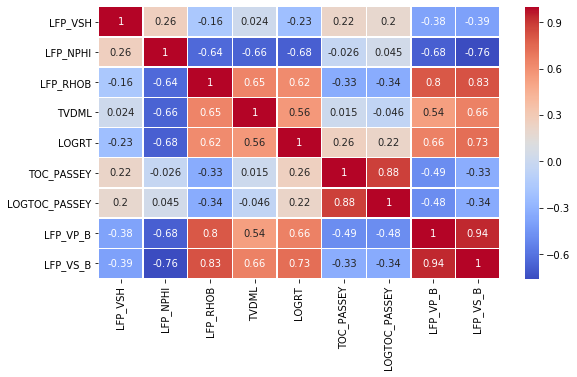

In [18]:
plt.figure(figsize=(9,5))
sns.heatmap(df3.corr(),cmap='coolwarm',annot=True,linewidth = 0.5)

## 9 Prepare the data for Machine Learning

In [19]:
short_list = ['TOC_PASSEY', 'LFP_VS_B']
df4 = df3[short_list]

short_list2 = ['TOC_PASSEY', 'LOGRT', 'TVDML', 'LFP_VS_B']
df5 = df3[short_list2]

In [20]:
# Evaluate Algorithms
num_folds = 10                     # 10-fold cross-validation
scoring = 'neg_mean_squared_error' # 0 is perfect in Mean Square Metric
seed = 7                           # for reproducibility
validation_size = 0.20 # 20% validation and 80% training

# Experiment 1 - one independent variable
#array = df4.values # Get the numpy.ndarray corresponding to the dataframe df
#X = array[:,0:1]   # Input variables X
#Y = array[:,1]     # Output variable Y
#X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

# Experiment 2 - two independent variables
array = df5.values # Get the numpy.ndarray corresponding to the dataframe df
X = array[:,0:3]   # Input variables X
Y = array[:,3]     # Output variable Y
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

### 9.1 Systematic evaluation of ML algorithms without standardization

In [21]:
models = []
# Linear ML algorithms
models.append(('EN', ElasticNet(), 'EN.pkl'))
models.append(('LASSO', Lasso(), 'LASSO.pkl'))
models.append(('LR', LinearRegression(), 'LR.pkl'))
models.append(('RIDGE', Ridge(), 'RIDGE.pkl'))
# Nonlinear ML algorithms
models.append(('CART_md3', DecisionTreeRegressor(max_depth=3), 'CART_md3.pkl'))
models.append(('CART_md4', DecisionTreeRegressor(max_depth=4), 'CART_md4.pkl'))
models.append(('CART_md5', DecisionTreeRegressor(max_depth=5), 'CART_md5.pkl'))
models.append(('CART_md6', DecisionTreeRegressor(max_depth=6), 'CART_md6.pkl'))
models.append(('KNN', KNeighborsRegressor(), 'KNN.pkl'))
models.append(('SVR', SVR(gamma='auto'), 'SVR.pkl'))

results = []
names = []
print("\nComparing algorithms without standardization (default KNN nn=7):\n")
for name, model, fname in models:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: mean = {cv_results.mean()}; std = {cv_results.std()}")
    # Save the model
    model.fit(X_train, Y_train) 
    pickle.dump(model, open(fname, 'wb'))


Comparing algorithms without standardization (default KNN nn=7):

EN: mean = -28966.633141934864; std = 2412.1272053844787
LASSO: mean = -15024.54587798764; std = 1319.3187767599009
LR: mean = -15020.314444754675; std = 1302.4971599882388
RIDGE: mean = -15020.339191055706; std = 1303.6264394240964
CART_md3: mean = -18911.672560136914; std = 1454.8731872593025
CART_md4: mean = -14260.320934571031; std = 1730.7608046086725
CART_md5: mean = -10808.511889131169; std = 1422.4719753080033
CART_md6: mean = -8459.89114329804; std = 1012.2284984807578
KNN: mean = -2072.542082089978; std = 638.2495188923838
SVR: mean = -104072.5289940878; std = 5992.616993033582


#### 9.1.1 General plotting of models - any number of independent variables

In [22]:
compare_VS_vals('LR.pkl', X_validation, Y_validation)


Contents of variable X_validation:
array([[9.158e+00, 9.395e-01, 2.550e+03],
       [8.268e+00, 9.471e-01, 2.555e+03],
       [3.414e+00, 1.896e+00, 3.415e+03],
       ...,
       [8.499e+00, 8.519e-01, 2.809e+03],
       [7.359e+00, 1.231e+00, 3.555e+03],
       [7.086e+00, 1.292e+00, 2.422e+03]])

Contents of variable Y_validation:
array([1303.815, 1391.413, 1871.609, ..., 1245.644, 1547.153, 1600.971])

Predicted value of the command "get_model.predict(X_validation)":
array([1247.152, 1298.482, 1985.558, ..., 1282.005, 1558.635, 1466.131])


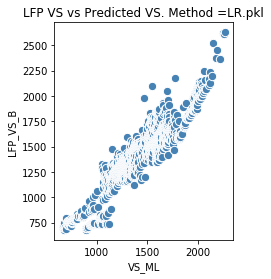

In [23]:
scatter_compare_VS(joblib.load('LR.pkl').predict(X_validation), Y_validation, 'LR.pkl')

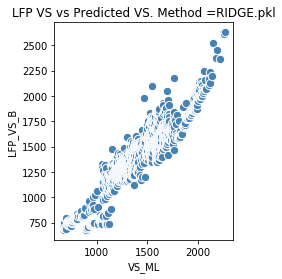

In [24]:
scatter_compare_VS(joblib.load('RIDGE.pkl').predict(X_validation), Y_validation, 'RIDGE.pkl')

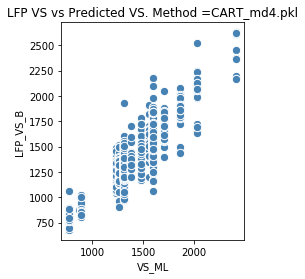

In [25]:
scatter_compare_VS(joblib.load('CART_md4.pkl').predict(X_validation), Y_validation, 'CART_md4.pkl')

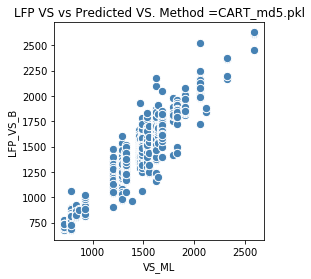

In [26]:
scatter_compare_VS(joblib.load('CART_md5.pkl').predict(X_validation), Y_validation, 'CART_md5.pkl')

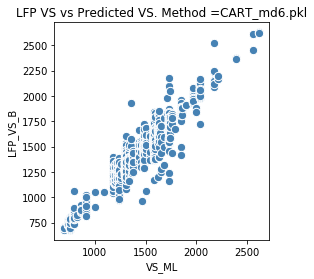

In [27]:
scatter_compare_VS(joblib.load('CART_md6.pkl').predict(X_validation), Y_validation, 'CART_md6.pkl')

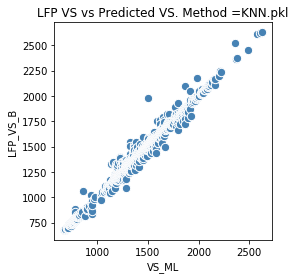

In [28]:
scatter_compare_VS(joblib.load('KNN.pkl').predict(X_validation), Y_validation, 'KNN.pkl')

### 9.2 Evaluate ML algorithms with standardization

In [29]:
pipelines = []
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())]), 'ScaledEN.pkl'))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())]), 'ScaledLASSO.pkl'))
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR', LinearRegression())]), 'ScaledLR.pkl'))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('Ridge', Ridge())]), 'ScaledRIDGE.pkl'))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())]), 'ScaledCART.pkl'))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())]), 'ScaledKNN.pkl'))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR', SVR(gamma='auto'))]), 'ScaledSVR'))

results = []
names = []
print("\nComparing algorithms with standardization (default KNN nn=7):\n")
for name, model, fname in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: mean = {cv_results.mean()}; std = {cv_results.std()}")
    # Save the model
    model.fit(X_train, Y_train) 
    pickle.dump(model, open(fname, 'wb'))


Comparing algorithms with standardization (default KNN nn=7):

ScaledEN: mean = -24883.9802094566; std = 2126.8197205649835
ScaledLASSO: mean = -15023.173862268148; std = 1313.0201524497422
ScaledLR: mean = -15020.314444754247; std = 1302.4971599882379
ScaledRIDGE: mean = -15020.31745588822; std = 1303.0944632053931
ScaledCART: mean = -3754.6686689420276; std = 1001.7214809617388
ScaledKNN: mean = -3211.8434734827492; std = 499.90341620982764
ScaledSVR: mean = -32533.01949266125; std = 2853.180741082263


### 9.4 Ensemble algorithms

In [30]:
ensembles = []
ensembles.append(('ScaledAB', 
                   Pipeline([('Scaler', StandardScaler()),('AB', AdaBoostRegressor())]), 
                   'ScaledAB.pkl'))
ensembles.append(('ScaledGBM', 
                   Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())]), 
                   'ScaledGBM.pkl'))
ensembles.append(('ScaledRF10', 
                   Pipeline([('Scaler', StandardScaler()),('RF', RandomForestRegressor(n_estimators=10))]),
                  'ScaledRF10.pkl'))
ensembles.append(('ScaledET09', 
                   Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=9))]),
                   'ScaledET09.pkl'))
ensembles.append(('ScaledET10', 
                   Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=10))]),
                   'ScaledET10.pkl'))
ensembles.append(('ScaledET11', 
                   Pipeline([('Scaler', StandardScaler()),('ET', ExtraTreesRegressor(n_estimators=11))]),
                   'ScaledET11.pkl'))
results = []
names = []
for name, model, fname in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    # Save the model
    model.fit(X_train, Y_train) 
    pickle.dump(model, open(fname, 'wb'))

ScaledAB: -16508.469914 (1484.425547)
ScaledGBM: -4945.193379 (559.309829)
ScaledRF10: -2405.529150 (508.346321)
ScaledET09: -1723.946730 (523.033581)
ScaledET10: -1749.347807 (430.417577)
ScaledET11: -1665.078684 (372.211644)


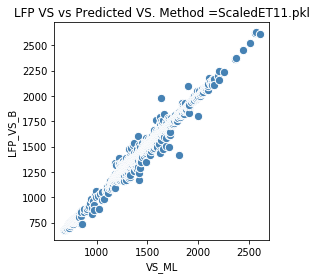

In [31]:
scatter_compare_VS(joblib.load('ScaledET11.pkl').predict(X_validation), Y_validation, 'ScaledET11.pkl')

### 9.5 Two examples of algorithm tuning

#### 9.5.1 Tuning scaled Gradient Boosting

In [32]:
# Tune scaled GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
param_grid = dict(n_estimators=np.array([50,100,200,400]))
model = GradientBoostingRegressor(random_state=seed)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold, iid=True)
grid_result = grid.fit(rescaledX, Y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -2208.220179 using {'n_estimators': 400}
-7445.108957 (856.594306) with: {'n_estimators': 50}
-4944.053710 (558.086477) with: {'n_estimators': 100}
-3105.604067 (442.250117) with: {'n_estimators': 200}
-2208.220179 (339.052631) with: {'n_estimators': 400}


#### 9.5.2 KNN Algorithm tuning wrt the number of nearest neighbours

In [33]:
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
k_values = np.array([1,3,5,7,9,11])
param_grid = dict(n_neighbors=k_values)
model = KNeighborsRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("\nOptimalization of number of neighbours in KNN:\n")
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Optimalization of number of neighbours in KNN:

Best: -3159.811084 using {'n_neighbors': 3}
-4144.477327 (748.331559) with: {'n_neighbors': 1}
-3159.811084 (499.988268) with: {'n_neighbors': 3}
-3210.108151 (500.582308) with: {'n_neighbors': 5}
-3376.352693 (498.405020) with: {'n_neighbors': 7}
-3549.689942 (519.881895) with: {'n_neighbors': 9}
-3697.167897 (539.149718) with: {'n_neighbors': 11}
